<a href="https://colab.research.google.com/github/raheelam98/Chatbot_Agents_Using_LangGraph/blob/main/customer_support/customer_support.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Customer Support**

LangGraph agents can manage customer inquiries, automate responses, and provide consistent, context-aware support across multiple channels.

In [1]:
# install the required packages

%%capture --no-stderr
%pip install -q -U langgraph langchain_google_genai langchain_core langchain_community tavily-python pandas openai


In [3]:
# API Keys
import os
from google.colab import userdata

os.environ["LANGCHAIN_API_KEY"] = userdata.get('LANGCHAIN_API_KEY')
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "quickstart"

gemini_api_key = userdata.get('GEMINI_API_KEY')

In [4]:
os.environ["TAVILY_API_KEY"] = userdata.get("TAVILY_API_KEY")

In [7]:
os.environ["OPENAI_API_KEY"] = userdata.get("OPENAI_API_KEY")

In [5]:
# check graph is running
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(
    model="gemini-1.5-flash",
    max_retries=2,
    api_key=gemini_api_key
)

response = llm.invoke([{"role": "user", "content": "greet me"}])

In [6]:
response

AIMessage(content='Hello there! How can I help you today? \n', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': [{'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability': 'NEGLIGIBLE', 'blocked': False}]}, id='run-534f017a-e737-4dd2-8ea5-696527d7c1bc-0', usage_metadata={'input_tokens': 3, 'output_tokens': 11, 'total_tokens': 14, 'input_token_details': {'cache_read': 0}})

In [8]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage, AIMessage , ToolMessage
from pydantic import BaseModel
from typing_extensions import TypedDict
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
#from langchain_core.messages import AIMessage, ToolMessage

# STEP 1
# (Part 1 : Basic Chatbot)
# add_messages: Append new messages to the existing list of messages in the state in the graph.
# Define the State class with a list of messages
class State(TypedDict):
    messages: Annotated[list, add_messages]
    # This flag indicates whether only a human can give instructions
    ask_human: bool   # (Part 6) True means only a human can give instructions


# STEP 2
class RequestAssistance(BaseModel):
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    request: str

# STEP 3
tool = TavilySearchResults(max_results=2)
tools = [tool]

# Bind the LLM (Large Language Model) to a tool definition, a pydantic model, or a JSON schema
# Now the LLM is capable of triggering both the Tool and the RequestAssistance Schema
llm_with_tools = llm.bind_tools(tools + [RequestAssistance])

# STEP 4 :-  default ask_human = False, LLM tells it is flase or true
# Define the chatbot node with modification of ask_human flag
# if response call tool_call then ask_human = true then it routes human route
# Define the chatbot function which uses the bound LLM and tools
def chatbot(state: State):
    # Invoke the LLM with the state messages
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False       # by default ask_human = False
    # Check if the response includes tool calls and if the first tool call is for RequestAssistance
    if (
        response.tool_calls
        and response.tool_calls[0]["name"] == RequestAssistance.__name__
    ):
        ask_human = True
    # Return the updated state with the response and ask_human flag
    return {"messages": [response], "ask_human": ask_human}

# STEP 5 :- create chatbot and tool node
# Create the graph builder and add the chatbot and tools nodes to the graph, same as before.
graph_builder = StateGraph(State)

# Add the chatbot node to the state graph
graph_builder.add_node("chatbot", chatbot)

# Add the tools node to the state graph with the specified tool
graph_builder.add_node("tools", ToolNode(tools=[tool]))

# STEP 6 :- create human node
def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )

# First create helper function for human_node functionality
def human_node(state: State):
    new_messages = []    # Create dictionary
    # Check if the last message from state is from ToolMessage
    if not isinstance(state["messages"][-1], ToolMessage):
        # Typically, the user will have updated the state during the interrupt.
        # If they choose not to, we will include a placeholder ToolMessage to let the LLM continue.
        # If the last message from state is not from ToolMessage
        # then append the generic response, No response from human.
        # Human node triggered but did not get the response.
        new_messages.append(
            create_response("No response from human.", state["messages"][-1])
        )
    return {
        # Append the new messages
        "messages": new_messages,
        # Unset the flag
        "ask_human": False, # To protect from infinite loop if no response from human
    }

# Add the human node to the state graph and pass human_node function
graph_builder.add_node("human", human_node)

# STEP 7 :- conditional logic
# When chatbot triggers for human: if ask_human is true, return human
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    # Otherwise, route as before
    return tools_condition(state)

graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", END: END},
)

# STEP 8 :
# The rest is the same
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = graph_builder.compile(
    checkpointer=memory,
    # We interrupt before 'human' here instead.
    interrupt_before=["human"],
)

Visualize the graph

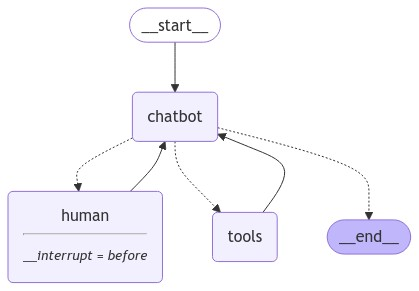

In [9]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

**Gather information**